<a href="https://colab.research.google.com/github/pbellot/ANFTDM2021/blob/main/ClassificationMetaISTEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Expériences en classifications automatiques de méta-données ISTEX

L'atelier donne des exemples pour :
- en Python : mettre en forme le fichier de données pour être lu facilement avec l'environnement WEKA
- en Python : extraire des colonnes du fichier d'origine pour une expérience en catégorisation automatique des documents. L'objectif est de retrouver le bon domaine scientifique d'un article à partir de son résumé
- avec Weka : vectoriser les résumés, appliquer un classifieur bayésien et un arbre de décision
- en Python : apprendre une représentation vectorielle dans un espace réduit des résumés à l'aide de l'approche Doc2Vec
- en Python : effectuer une classification non supervisée à l'aide de deux méthodes de partitionnement (k-Moyennes et cartes auto-organisées) et visualiser le résultat via une ACP.

Connexion Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## les imports nécessaires

In [ ]:
#pour Google Colab, somoclu est à ré-installer à chaque exécution
!pip install somoclu

     |████████████████████████████████| 6.2MB 7.1MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=421933 sha256=ffb8c772c1484e5eef9d51605412290e2890d078f69d316027a09eeedaf363a7
  Stored in directory: /root/.cache/pip/wheels/a6/e2/a0/4a61002b47e4965d7f59fd4c7ccf2e86a03ccad366f978d2a7
Successfully built somoclu


In [ ]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm
import nltk
import gensim
import seaborn as sn
import numpy as np
import somoclu

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from nltk.corpus import stopwords
from gensim.models import Doc2Vec

## Mise en forme en .csv pour Weka du fichier Corpus SARS-MERS-Export.csv

### Lecture du fichier de départ Corpus SARS-MERS-Export.csv

In [ ]:
fichierCSVEntree = "/content/drive/MyDrive/Colab Notebooks/CorpusCovid.csv"
fichierSortie = "/content/drive/MyDrive/Colab Notebooks/CorpusWeka.csv"

print("Ouverture fichier : ", fichierCSVEntree)
data = pd.read_csv(fichierCSVEntree, sep=";", header=0, error_bad_lines=False, encoding="utf_8", usecols=[0,1,13,14,15,16], names=["Nom","Titre","Langue","Resume","MotsCles","Categories"])
data.head()

Ouverture fichier :  /content/drive/MyDrive/Colab Notebooks/CorpusCovid.csv


,Nom,Titre,Langue,Resume,MotsCles,Categories
0,sars-mers_00002,Structures and diseases,Anglais,Structural biology is making significant contr...,NaN,1 - science ; 2 - cell biology ; 2 - biophysic...
1,sars-mers_00003,Evaluating Euro-Mediterranean Relations,Anglais,What are the prospects for the future of the E...,NaN,NaN
2,sars-mers_00005,Emerging pathogens and their implications for ...,Anglais,The threat of infection by conventional transf...,blood transfusion ; safety ; emerging infections,1 - science ; 2 - hematology
3,sars-mers_00006,Pandémie grippale A/H5N1 et niveau de préparat...,Français,"Résumé: Dans les pays industrialisés, l’émerge...",Pandémie grippale ; Professionnels de santé ; ...,NaN
4,sars-mers_00007,Planetary science: Mission to Earth's core — a...,Anglais,"Not science fiction, but a technically feasibl...",NaN,1 - science ; 2 - multidisciplinary sciences


### Exploration générale

In [ ]:
print("Résumé du 1er document :\n", data['Resume'][0])
print("Résumé du 2è document :\n", data['Resume'][1])

Résumé du 1er document :
 Structural biology is making significant contributions toward an understanding of molecular constituents and mechanisms underlying human diseases at an atomic resolution, as discussed at the international Murnau Conference on Structural Biology of Disease Mechanisms held in September 2007 in Murnau, Germany.
Résumé du 2è document :
 What are the prospects for the future of the Euro-Mediterranean area and what relevant role can the Euro-Mediterranean Partnership play in this future? After decades of a Mediterranean policy that was actually focused more on improving economic relations between Europe and the Mediterranean riparian states than anything else, the EU launched a more comprehensive Mediterranean policy in November 1995, the Euro-Mediterranean Partnership (EMP). The EMP has embraced political and security relations and socio-cultural relations as well as taking economics into account. As the tenth anniversary of this partnership approaches, this book d

Nombre total de documents :   2532 (2532, 6)
Nombre de documents en français :  67
Documents en  Anglais  :  2197
Documents en  Français  :  67
Documents en  Indéterminé  :  230
Documents en  Allemand  :  38
Les mots les plus fréquents par langue dans les titres : 
pour langue  Anglais  :  [('of', 1543), ('and', 973), ('in', 852), ('the', 774), ('a', 451), ('for', 338), ('respiratory', 281), ('acute', 229), ('to', 217), ('with', 217), ('sars', 204), ('severe', 204), ('coronavirus', 202), ('virus', 198), ('syndrome', 179), ('on', 164), ('by', 162), ('from', 150), ('human', 138), ('protein', 131), ('an', 114), ('viral', 101), ('infection', 84), ('analysis', 82), ('infectious', 82)]


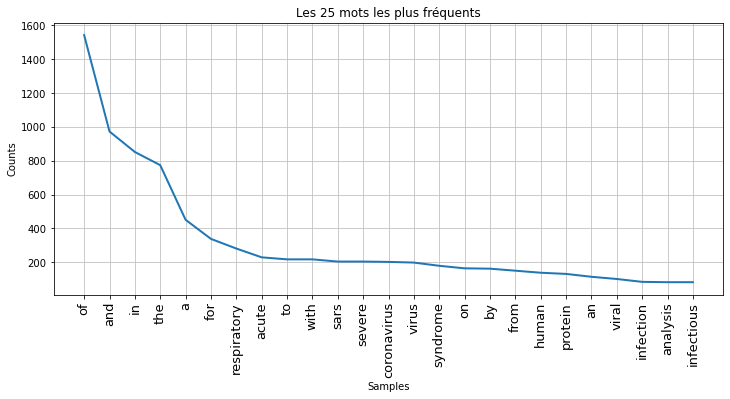

pour langue  Français  :  [('de', 41), ('des', 29), ('la', 29), ('et', 18), ('les', 14), ('le', 14), ('en', 11), (':', 10), ('à', 10), ('du', 9), ('virus', 9), ('un', 8), ('au', 6), ('sur', 5), ('brèves', 5), ('dans', 4), ('santé', 4), ('une', 3), ('prise', 3), ('charge', 3), ('international', 3), ('développement', 3), ('entre', 3), ('?', 3), ('nouvelles', 3)]


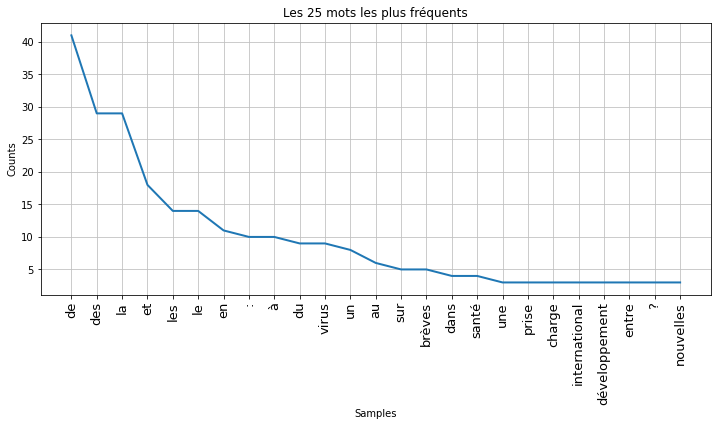

pour langue  Indéterminé  :  [('of', 170), ('and', 112), ('in', 112), ('the', 90), ('respiratory', 85), ('acute', 74), ('severe', 65), ('a', 57), ('with', 52), ('syndrome', 49), ('coronavirus', 49), ('for', 39), ('human', 37), ('by', 30), ('infection', 25), ('to', 23), ('viral', 20), ('virus', 17), ('patients', 17), ('influenza', 16), ('from', 14), ('clinical', 13), ('on', 12), ('disease', 12), ('is', 12)]


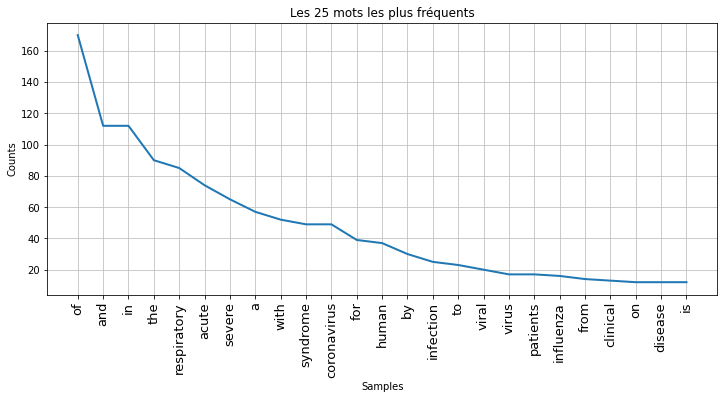

pour langue  Allemand  :  [('der', 10), ('und', 9), ('in', 4), ('für', 4), ('angew.', 4), ('chem.', 4), ('von', 3), ('die', 3), ('zur', 3), ('gegen', 2), ('en', 2), ('iso', 2), ('15189', 2), ('ein', 2), ('/', 2), ('for', 2), ('virale', 2), ('erwachsene', 2), ('neue', 2), ('viren', 2), ('management', 2), ('anschläge', 2), ('durch', 2), ('graphisches', 2), ('inhaltsverzeichnis:', 2)]


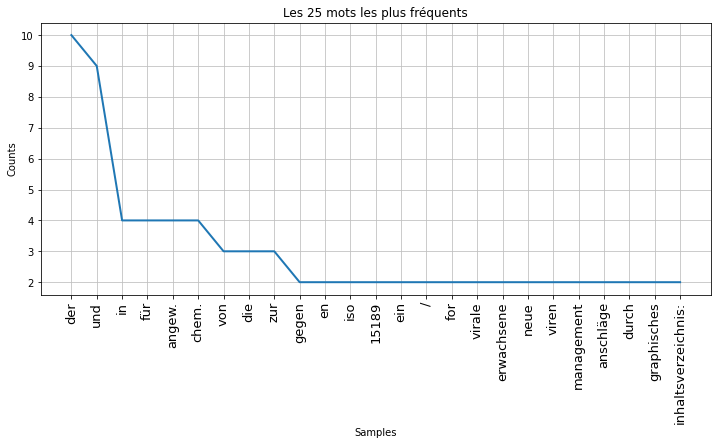

Les mots les plus fréquents par langue dans les résumés : 
pour langue  Anglais  :  [('the', 16828), ('of', 13315), ('and', 10853), ('in', 7480), ('to', 6021), ('a', 5277), ('for', 3431), ('with', 2952), ('is', 2420), ('that', 2405), ('by', 1999), ('was', 1995), ('were', 1990), ('as', 1877), ('this', 1550), ('are', 1529), ('from', 1489), ('on', 1435), ('be', 1236), ('we', 1221), ('an', 1158), ('have', 1004), ('virus', 947), ('respiratory', 919), ('these', 902)]
pour langue  Français  :  [('de', 249), ('la', 144), ('des', 110), ('les', 102), ('et', 102), ('le', 61), ('à', 57), ('en', 57), ('du', 46), ('un', 36), ('une', 35), ('dans', 34), ('est', 30), ('a', 29), ('que', 29), ('sur', 28), ('pour', 27), ('par', 25), ('ces', 22), ('virus', 20), ('ont', 20), ('au', 19), ('cette', 17), ('sont', 17), ('nous', 16)]
pour langue  Indéterminé  :  [('the', 1521), ('of', 1335), ('and', 1059), ('in', 770), ('a', 518), ('to', 507), ('with', 467), ('for', 329), ('that', 290), ('were', 280), ('was', 26

In [ ]:
#Nombre d'instances (de documents ou encore de lignes)
print('Nombre total de documents :  ',len(data), data.shape)
#Nombre de document par langue
print("Nombre de documents en français : ", len(data[data.Langue=='Français']))
for langue in data['Langue'].unique():
    print("Documents en ", langue, " : ", len(data[data.Langue==langue]))
data.groupby('Langue', dropna=False).describe()

print("Les mots les plus fréquents par langue dans les titres : ")
for langue in data['Langue'].unique():
    mots_des_titres = []
    for titre in list(data['Titre'][data.Langue==langue]):
        mots = titre.split()
        for mot in mots:
            mots_des_titres.append(mot.lower())
    print("pour langue ", langue, " : ", Counter(mots_des_titres).most_common(25))
    # plot word frequency distribution of first few words
    plt.figure(figsize=(12,5))
    plt.title('Les 25 mots les plus fréquents')
    plt.xticks(fontsize=13, rotation=90)
    fd = nltk.FreqDist(mots_des_titres)
    fd.plot(25,cumulative=False)

print("Les mots les plus fréquents par langue dans les résumés : ")
for langue in data['Langue'].unique():
    mots_des_resumes = []
    for texte in data['Resume'][data.Langue==langue]:
        if isinstance(texte,str):
            mots = texte.split()
            for mot in mots:
                mots_des_resumes.append(mot.lower())
    print("pour langue ", langue, " : ", Counter(mots_des_resumes).most_common(25))

#### Elimination des mots outils
(pour le comptage seulement : ils seront conservés dans le fichier de sortie)

Les mots les plus fréquents par langue dans les résumés après suppression des mots outils : 
pour langue  Anglais  :  [('virus', 947), ('respiratory', 919), ('protein', 855), ('viral', 821), ('sars', 794), ('human', 687), ('patients', 650), ('using', 583), ('acute', 568), ('also', 567), ('severe', 512), ('infection', 508), ('used', 507), ('may', 501), ('disease', 497), ('cells', 486), ('new', 458), ('viruses', 457), ('study', 454), ('cell', 454), ('two', 449), ('syndrome', 427), ('results', 406), ('proteins', 392), ('rna', 388)]


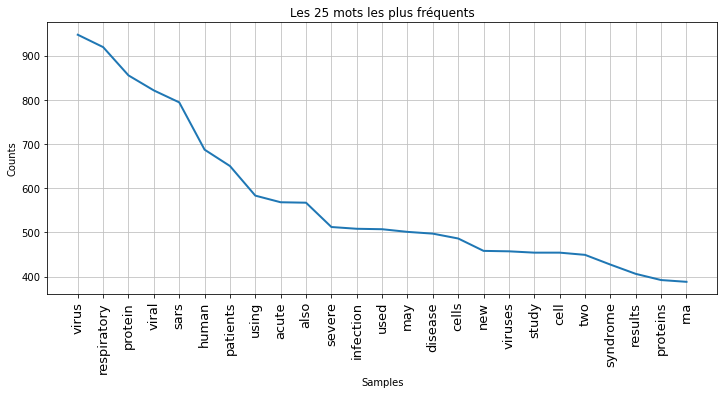

pour langue  Français  :  [('a', 29), ('virus', 20), ('cette', 17), ('plus', 15), ('chez', 13), ('d’une', 13), ('système', 9), ('comme', 9), ('développement', 8), ('voie', 8), ('sras', 8), ('d’un', 7), ('fait', 7), ('ainsi', 7), ('arn', 7), ('mécanismes', 7), ('nouvelles', 7), ('vaccins', 7), ('coiffe', 7), ('agents', 6), ("l'eca", 6), ('plusieurs', 6), ('bien', 6), ('encore', 6), ('nombreux', 6)]


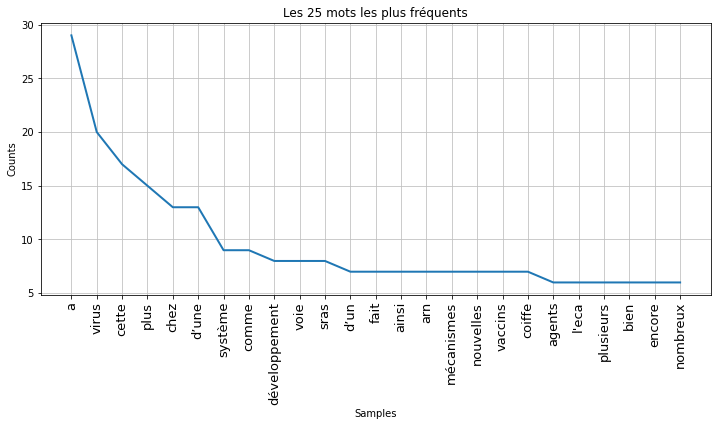

pour langue  Indéterminé  :  [('the', 1521), ('of', 1335), ('and', 1059), ('a', 518), ('to', 507), ('with', 467), ('for', 329), ('that', 290), ('were', 280), ('by', 223), ('is', 190), ('from', 180), ('patients', 163), ('respiratory', 157), ('we', 152), ('sars', 144), ('be', 136), ('as', 132), ('on', 126), ('are', 119), ('viral', 118), ('virus', 116), ('or', 104), ('acute', 99), ('this', 97)]


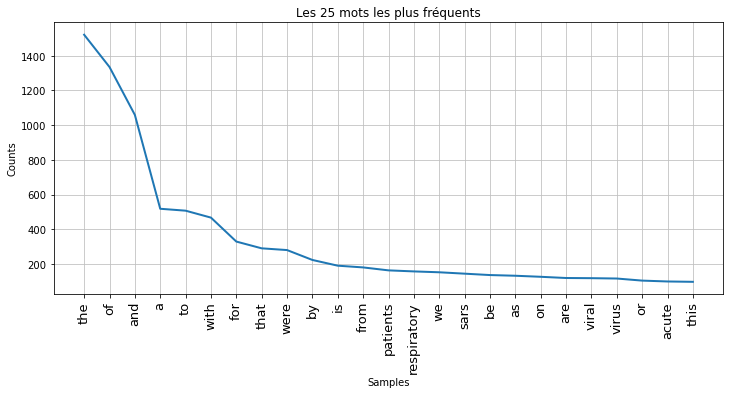

pour langue  Allemand  :  [('infektionskrankheiten', 9), ('neue', 9), ('zusammenfassung:', 8), ('menschen', 8), ('deutschland', 7), ('neuen', 7), ('poct', 6), ('erkrankungen', 6), ('thoraxkompressionen', 6), ('2', 6), ('erreger', 5), ('wurde', 5), ('qualität', 5), ('jedoch', 5), ('infektionsschutz', 5), ('öle', 4), ('therapie', 4), ('infektionen', 4), ('medizinischen', 4), ('möglicherweise', 4), ('bedeutung', 4), ('versorgung', 4), ('patienten', 4), ('sind.', 4), ('können.', 4)]


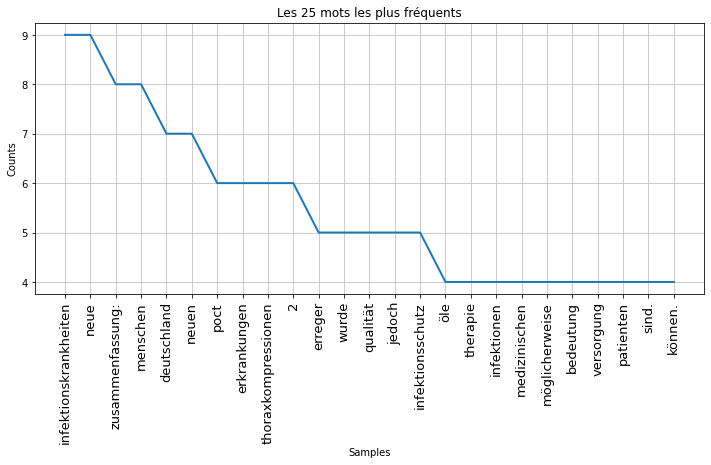

In [ ]:
print("Les mots les plus fréquents par langue dans les résumés après suppression des mots outils : ")
for langue in data['Langue'].unique():
    mots_des_resumes = []
    stop_words = []
    if langue.lower() == "anglais":
        stop_words = stopwords.words('english')
    elif langue.lower() == "français":
        stop_words = stopwords.words('french')
    else:
        stop_words = stopwords.words('german')
    for texte in data['Resume'][data.Langue==langue]:
        if isinstance(texte,str):
            mots = texte.split()
            for mot in mots:
                if mot.lower() not in stop_words:
                    mots_des_resumes.append(mot.lower())
    print("pour langue ", langue, " : ", Counter(mots_des_resumes).most_common(25))
    # plot word frequency distribution of first few words
    plt.figure(figsize=(12,5))
    plt.title('Les 25 mots les plus fréquents')
    plt.xticks(fontsize=13, rotation=90)
    fd = nltk.FreqDist(mots_des_resumes)
    fd.plot(25,cumulative=False)

### Enregistrement du fichier complet pour Weka
(à titre indicatif car on ne l'utilisera pas ensuite)

In [ ]:
data.to_csv(fichierSortie,sep=',',na_rep='?', index = False, header=True, quoting=csv.QUOTE_NONNUMERIC, quotechar='"', doublequote=False, escapechar='\\')

## Extraction des colonnes Résumés et Catégories seules et enregistrement en .csv pour Weka
### Traitement de la colonne catégories en ne gardant qu'une seule catégorie par document
(la 1ère catégorie du niveau 2 si elle existe, la catégorie de niveau 1 sinon)
NB : les lignes dont la catégorie ou bien le résumé sont absents sont supprimées


In [ ]:
resumesClasses = data[['Resume','Categories']][data['Resume'].notnull()]
resumesClasses = resumesClasses[resumesClasses['Categories'].notnull()]

import re
for index, row in resumesClasses.iterrows():
    cat = str(row['Categories'])
    catRetenue = re.search(" 2 - ([a-z]+)", cat)
    if catRetenue:
        row['Categories'] = catRetenue[1]
    else:
        catRetenue = re.search("1 - ([a-z]+)", cat)
        if catRetenue:
            row['Categories'] = catRetenue[1]

print(resumesClasses.head())
print("Nombre de documents présents : ", len(resumesClasses))

                                               Resume         Categories
0   Structural biology is making significant contr...               cell
2   The threat of infection by conventional transf...         hematology
4   Not science fiction, but a technically feasibl...  multidisciplinary
6   Severe acute respiratory syndrome coronavirus ...          chemistry
11  Objective: To understand the association betwe...             public
Nombre de documents présents :  1276


In [ ]:
fichierSortie = "/content/drive/MyDrive/Colab Notebooks/CorpusWekaResumes.csv"
resumesClasses.to_csv(fichierSortie,sep=',',na_rep='?', index = False, header=True, quoting=csv.QUOTE_NONNUMERIC, quotechar='"', doublequote=False, escapechar='\\')

## Classfication non supervisée
### Représentation vectorielle réduite des textes (Doc2Vec)

voir :
Documentation : https://radimrehurek.com/gensim/models/doc2vec.html

Présentation : https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

Exemple: https://www.kaggle.com/phyothuhtet/document-clustering-self-organizing-map-kmeans

CPU times: user 6.15 s, sys: 153 ms, total: 6.3 s
Wall time: 3.82 s


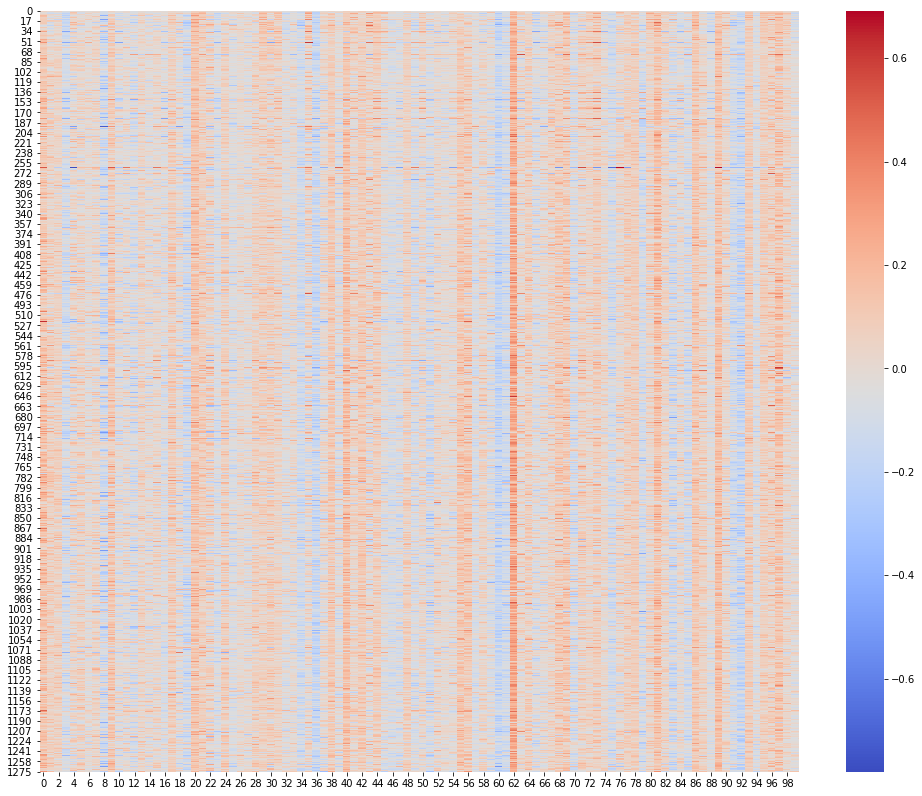

In [ ]:
def doc2vect():
    document_tagged  = []
    tagged_count = 0
    for _ in resumesClasses['Resume'].values:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(_,[tagged_count]))
        tagged_count += 1
    d2v = Doc2Vec(document_tagged)
    #return d2v.docvecs.vectors_docs
    return d2v.dv.vectors #pour version 09.2021 de Gensim

%time doc2vec = doc2vect()

plt.figure(figsize=(17,14))
sn.heatmap(doc2vec, cmap = "coolwarm")

## KMeans puis ACP pour visualisation

Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

CPU times: user 38.1 ms, sys: 34.7 ms, total: 72.7 ms
Wall time: 1.28 s
intertie intra-classes :  610.1857653597009


<Figure size 3600x1440 with 0 Axes>

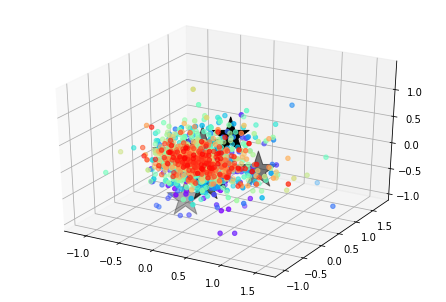

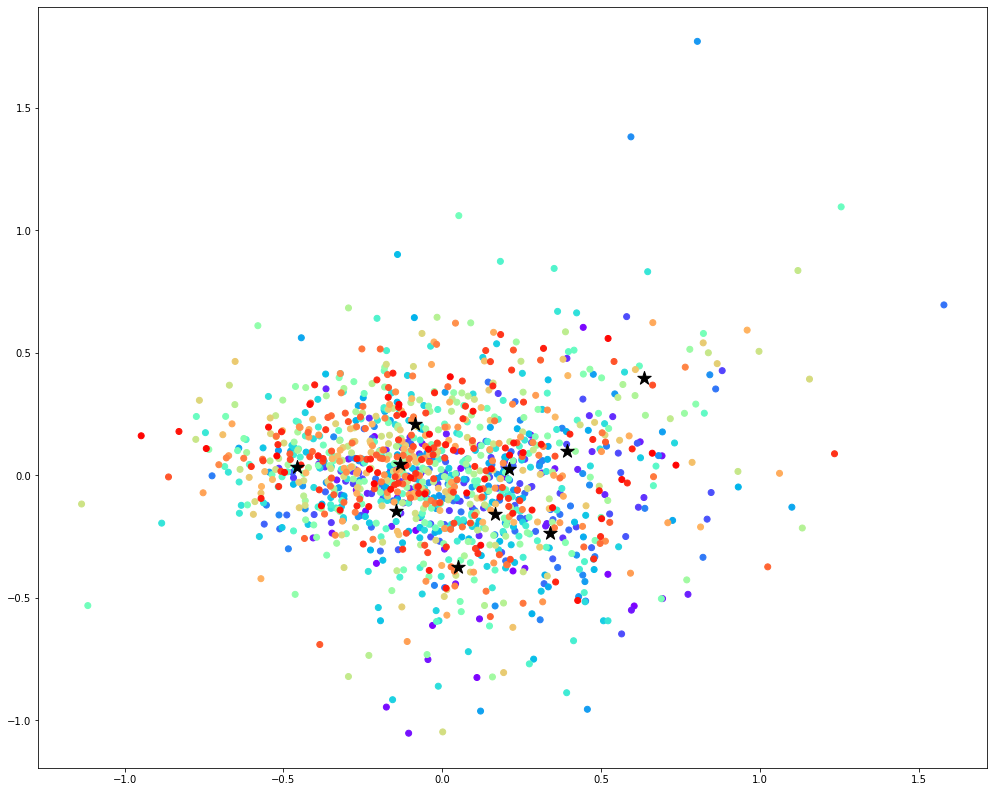

In [ ]:
kmean_model = KMeans(n_clusters=10, n_jobs=-1)
%time km = kmean_model.fit_predict(doc2vec)
print ("intertie intra-classes : ", kmean_model.inertia_)

pca = PCA(n_components=3).fit(doc2vec)
data = pca.transform(doc2vec)
centroids = pca.transform(kmean_model.cluster_centers_)

color = matplotlib.cm.rainbow(np.linspace(0, 1, len(kmean_model.labels_)))
plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(data[:, 0], data[:, 1],data[:, 2],c = color)
axis.scatter(centroids[:, 0], centroids[:, 1], centroids[:,2], marker='*', s=1500, c='#000000')
plt.show()

plt.figure(figsize=(17,14))
plt.scatter(data[:, 0], data[:, 1],c = color)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='#000000')
plt.show()

## Cartes auto-organisées
Expérimentations avec plusieurs nombres de lignes et de colonnes

Documentation : https://somoclu.readthedocs.io/en/stable/

Matrice 4 x 4


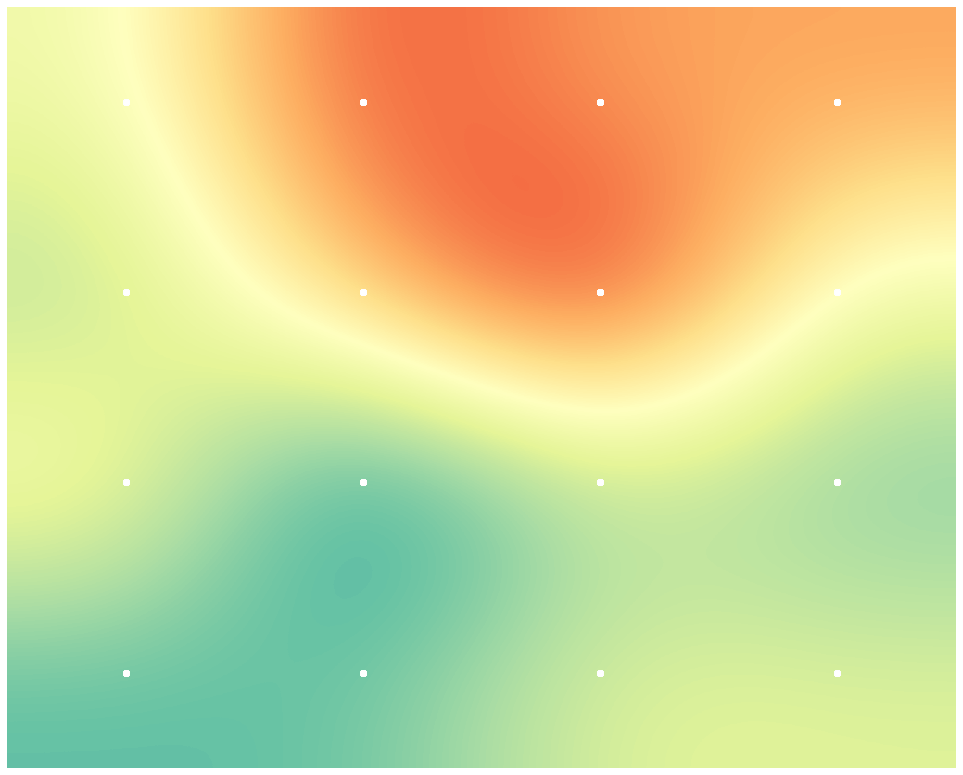

<module 'matplotlib.pyplot' from '/Users/Patrice/opt/anaconda3/envs/py371/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [ ]:
print("Matrice 4 x 4")
som = somoclu.Somoclu(4, 4, maptype="toroid")
som.train(doc2vec)
som.view_umatrix(bestmatches=True, figsize=(17,14))

Matrice 10 x 10


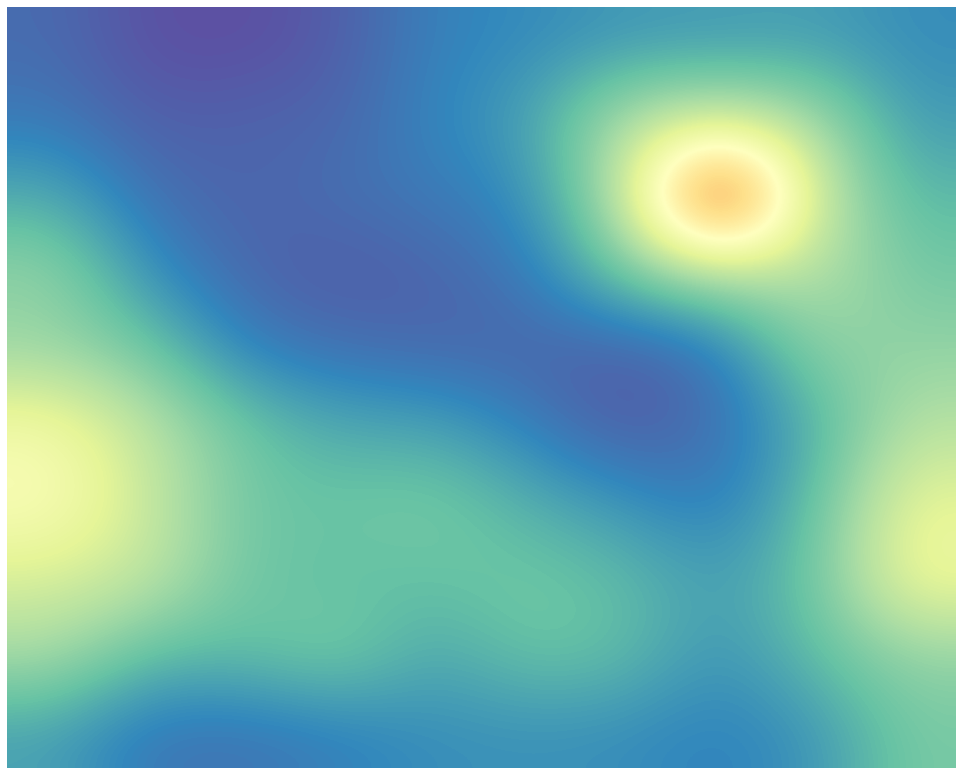

<module 'matplotlib.pyplot' from '/Users/Patrice/opt/anaconda3/envs/py371/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [ ]:
print("Matrice 10 x 10")
som = somoclu.Somoclu(10, 10, maptype="toroid")
som.train(doc2vec)
som.view_umatrix(bestmatches=False, figsize=(17,14))

Matrice 30 x 30


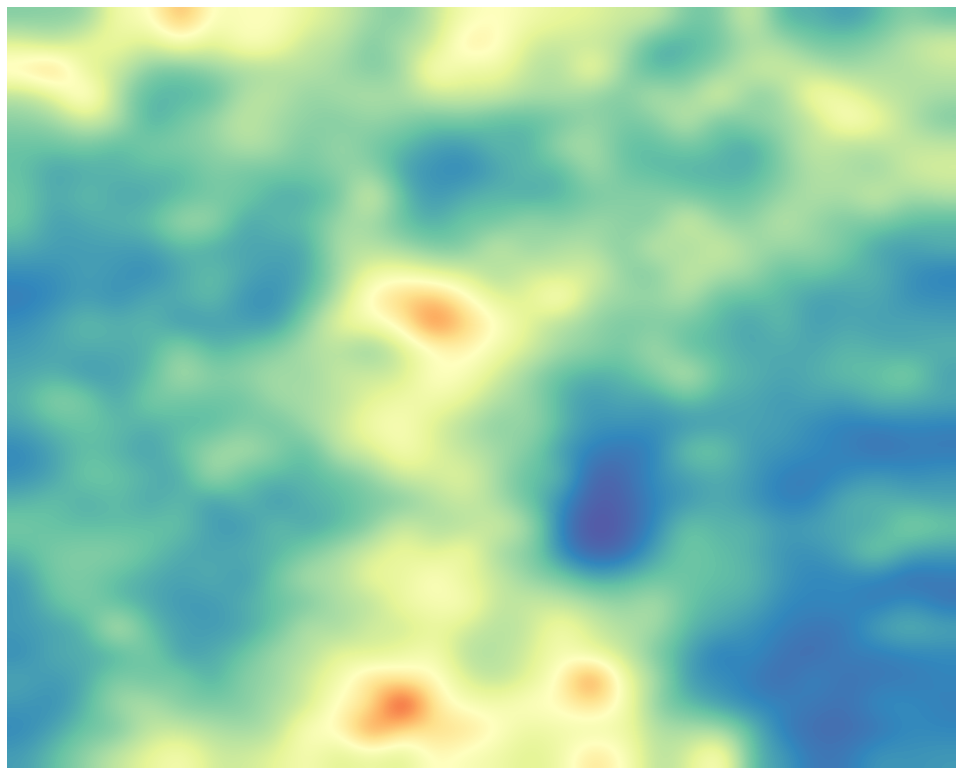

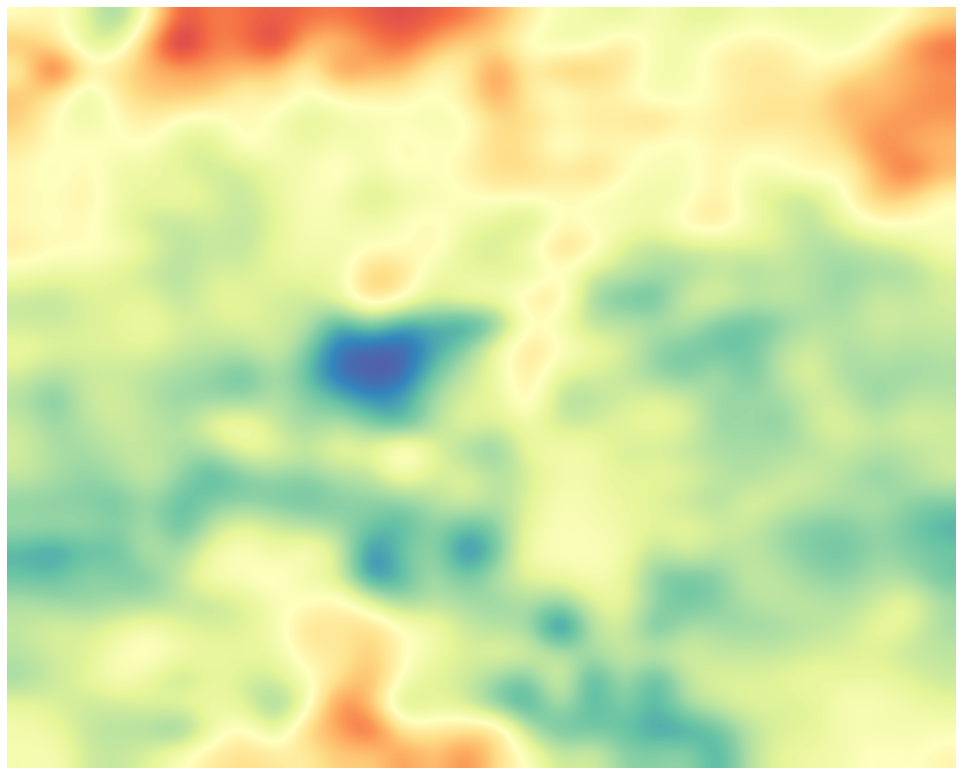

<module 'matplotlib.pyplot' from '/Users/Patrice/opt/anaconda3/envs/py371/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [ ]:
print("Matrice 30 x 30")
som = somoclu.Somoclu(30, 30, maptype="toroid")
som.train(doc2vec)
som.view_umatrix(bestmatches=False, figsize=(17,14))

som.view_component_planes(dimensions=[1], figsize=(17,14))